### Import scanpy

In [1]:
import scanpy as sc
import scanpy.external as sce
#sc.logging.print_versions()
#sc.logging.print_memory_usage()
#sc.settings.verbosity = 2
import os,sys
import datetime
import numpy as np
import pandas as pd
import math
import matplotlib.ticker as mticker


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
from matplotlib import cm
from matplotlib.lines import Line2D
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker

In [3]:
# add the utility function folder to PATH
sys.path.append(os.path.abspath("utility_functions_190403_12h24/"))

from rz_import_statements import *
import rz_functions as rz
import rz_fig_params # this adjust mpl.rcParams, almost nothing to import, import after scanpy to overwrite rc.Params
import rz_utility_spring as srz

python version: 3.8.12


# Load data

In [4]:
adata = sc.read_h5ad('backups_JZ_2022/clean_kidney_304_15tr_25c_batch_corrected_50236x2000_220315_12h14.h5ad') 

In [5]:
# overwrite obs with the most recent version
filename = 'backups_JZ_2022/corrected_obs_info_50236x32_221012_12h04.npz'
encoding = 'latin1'

with np.load(filename,encoding=encoding, allow_pickle = True) as f:
    obs = pd.DataFrame(**f)
adata.obs = obs

In [6]:
adata.obs

,library,total_counts,pct_counts_mito,library2,sample,patient,pT stage,seq_date,beads,operation,...,n_counts,no_dblt_no_rbc,sp_cl_43,cell_type,broad_cell_type,color,cell_group,stage_color,patient_color,group_color
2,N14,449,0.668151,T2_1,T2,P2,pT3a,20_11_12,old,Open,...,449,True,40,TAM 4,Immune,#9a5ce0,Myeloid cells,#8c1a1a,#e87f7f,#85619c
19,N14,449,4.23163,T2_1,T2,P2,pT3a,20_11_12,old,Open,...,449,True,37,TAM 3,Immune,#943886,Myeloid cells,#8c1a1a,#e87f7f,#85619c
363,N14,1229,10.6591,T2_1,T2,P2,pT3a,20_11_12,old,Open,...,1229,True,22,Tumor cells 2,Tumor,#b06c6c,Tumor cells,#8c1a1a,#e87f7f,#db2f2c
433,N14,432,6.94444,T2_1,T2,P2,pT3a,20_11_12,old,Open,...,432,True,27,Tumor cells 3,Tumor,#db2f2c,Tumor cells,#8c1a1a,#e87f7f,#db2f2c
444,N14,502,4.98008,T2_1,T2,P2,pT3a,20_11_12,old,Open,...,502,True,28,Tumor vasculature 4,Endothelial,#a35927,Endothelium,#8c1a1a,#e87f7f,#e07c57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4865536,Tumor0228,683,9.37042,T4_old,T4,P4,pT3a,old,old,Open,...,683,True,30,TAM 2,Immune,#532b6b,Myeloid cells,#8c1a1a,#70c3d4,#85619c
4865584,Tumor0228,1473,6.51731,T4_old,T4,P4,pT3a,old,old,Open,...,1473,True,30,TAM 2,Immune,#532b6b,Myeloid cells,#8c1a1a,#70c3d4,#85619c
4865642,Tumor0228,498,9.43775,T4_old,T4,P4,pT3a,old,old,Open,...,498,True,37,TAM 3,Immune,#943886,Myeloid cells,#8c1a1a,#70c3d4,#85619c
4865726,Tumor0228,421,19.2399,T4_old,T4,P4,pT3a,old,old,Open,...,421,True,27,Tumor cells 3,Tumor,#db2f2c,Tumor cells,#8c1a1a,#70c3d4,#db2f2c


### Scale (normalize) data

In [7]:
adata = adata.raw.to_adata()

In [9]:
# turn into counts per 10k
print(adata.X[:5,:].sum(axis=1))
print()
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
print(adata.X[:5,:].sum(axis=1))

[[ 449.]
 [ 449.]
 [1229.]
 [ 432.]
 [ 502.]]

[[10000.001]
 [10000.   ]
 [10000.001]
 [10000.   ]
 [10000.   ]]


In [10]:
import matplotlib as mpl
mpl.rc('font',family='Arial')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# Get enriched genes

In [11]:
adata.obs['cell_type'].unique()

array(['TAM 4', 'TAM 3', 'Tumor cells 2', 'Tumor cells 3',
       'Tumor vasculature 4', 'TAM 1', 'CD8 T cells', 'TAM 2',
       'Resting/memory T cells', 'Cytotoxic T cells',
       'Tumor vasculature 2', 'Tumor vasculature 1',
       'Non-classical monocytes', 'Mesangial/vSMCs',
       'IGHG-high plasma cells', 'Mast cells', 'Tumor vasculature 3',
       'Plasma cells', 'Tumor AVR-like vasculature', 'Cycling', 'vSMCs',
       'NK cells', 'Classical monocytes', 'B cells', 'Myofibroblasts',
       'Regulatory T cells', 'Tumor cells 1', 'Proximal tubule', 'AVR',
       'Epithelial progenitor-like cells', 'tAL of LOH',
       'Glomerular endothelium', 'Principal cells', 'TAL of LOH', 'DVR',
       'Type A-ICs', 'OM Type A-ICs', 'Type B-IC', 'Podocytes', 'DCT/CNT'],
      dtype=object)

In [12]:
#subset cells using cmask
cmask = adata.obs['cell_type'].isin([ 'Tumor cells 1','Tumor cells 2', 'Tumor cells 3']).values
print(cmask.sum())

3039


In [13]:
# get centroids
thelabel = 'cell_type'
centroids = rz.centroids(thelabel,adata[cmask])

In [14]:
# For each cluster, find genes that are statistically significantly higher or lower in cluster x compared to
# all other cells collectively

#label-free filter to remove low abundance genes
# I am using a more stringent filter here of 50 cells

min_counts = 15
min_cells = 50

In [15]:
gmask = srz.filter_abund_genes(adata.X[cmask], min_counts, min_cells)

1267 genes passing abundance filter


In [16]:
mwu_dict = {}
start=time.time()
counter=0

meta = adata[cmask].obs
E = adata[cmask].X
gene_list = adata.var_names


for cluster in meta[thelabel].unique():
    counter+=1
    mask1 = (meta[thelabel]==cluster).values
    mask2 = mask1==False
    
    cg1 = np.array(E[:,gmask][mask1,:].todense())
    cg2 = np.array(E[:,gmask][mask2,:].todense())
    mwu_dict[cluster] = rz.mwu(cg1,cg2,genes=gene_list[gmask],print_progression=True)
    print("%d/%d"%(counter,len(meta[thelabel].unique())))
    print(cluster, 'done',cg1.shape[0]+cg2.shape[0])
print(time.time()-start)

fname = 'backups_JZ_2022/1550_tumor_clusters_vs_rest_MWU_result_dict_%s%s'%(rz.now(), thelabel)
print(fname)
rz.save_stuff(mwu_dict,fname)

1000
1/3
Tumor cells 2 done 3039
1000
2/3
Tumor cells 3 done 3039
1000
3/3
Tumor cells 1 done 3039
5.446923017501831
backups_JZ_2022/1550_tumor_clusters_vs_rest_MWU_result_dict_230617_12h32cell_type


In [17]:
#continuing from backup
#mwu_dict = rz.load_stuff('backups_JZ_2022/1515vasculature_clusters_vs_rest_MWU_result_dict_221109_15h58cell_type.pickle')

In [18]:
# select pseudovalue to add
pseudo = 1 # 1 counts per 10k

In [19]:
print(thelabel)
fcdict = rz.get_fc_to_all_other(
        lab = thelabel,
        meta = adata[cmask].obs,
        E = adata[cmask].X,
        pseudo = pseudo,
        gene_list = adata.var_names,
        )

cell_type


In [20]:
# leave only genes with a significant difference.
fcdictsig = {}

# before the mwu test, I prefiltered genes on abundance, apply this mask here as well
print(gmask.sum())
for key,value in fcdict.items():
    sigmask = (mwu_dict[key]['fdr']<0.05).values
    fcdictsig[key] = value[gmask][sigmask]
    print(key,sigmask.sum(),len(fcdictsig[key]))

1267
Tumor cells 2 1180 1180
Tumor cells 3 1219 1219
Tumor cells 1 1070 1070


In [21]:
# nr genes to consider:

upto = 20 #genes to generate heatmap

frame = {}
for key,value in fcdictsig.items():
    s = value.sort_values(ascending=False)[:upto]
    key2 = str(key)+'_FC'
    frame[str(key)] = s.index
    frame[key2] = s.values
frame = pd.DataFrame(frame)
frame[[i for i in frame.columns if "FC" in i]].min() #ok, all above 1.

Tumor cells 2_FC    1.750194
Tumor cells 3_FC    1.424685
Tumor cells 1_FC    2.994534
dtype: float32

In [22]:
outdir = 'outputs_JZ_2022/'

In [23]:
fname = outdir+'tumor_lists1550_enriched_genes_top_%d_%s_%s.xlsx'%(upto,thelabel,rz.now())
print(fname)
frame.to_excel(fname)

outputs_JZ_2022/tumor_lists1550_enriched_genes_top_20_cell_type_230617_12h32.xlsx


In [24]:
frame

,Tumor cells 2,Tumor cells 2_FC,Tumor cells 3,Tumor cells 3_FC,Tumor cells 1,Tumor cells 1_FC
0,PDK4,2.620956,TGFBI,2.013462,GC,10.292252
1,TNFAIP6,2.564194,APOC1,2.010990,FABP7,6.979539
2,NAT8,2.432796,APOE,1.966565,IFI27,6.158026
3,SMIM24,2.114027,EEF1A1,1.663460,HSPA1B,5.408942
4,NNMT,2.061851,RPLP0,1.652715,UBD,5.120883
5,CEBPD,2.049349,RPL3,1.612963,MDK,5.070866
6,VEGFA,2.048639,CCL4,1.587750,HLA-G,4.366031
7,SLC3A1,1.981532,SLC25A5,1.567456,SLC17A3,3.860393
8,KLF6,1.973939,RPS17,1.525232,ATP5MC3,3.778892
9,RETREG1,1.922115,NAP1L1,1.518389,HSPA1A,3.706318


### Perform hierarchical clustering and plot heatmap

In [28]:
clnames = sorted(mwu_dict.keys())


In [29]:
# select only columns with gene names:
genes = frame[clnames].values.flatten()
print(len(genes))

# I anticipate some genes to be repeated
genes = rz.oset(genes)
print(len(genes))

# select centroids expression data
heat = centroids[genes].copy()

# transform:
heat = heat + pseudo
heat = heat/heat.median()
heat = np.log2(heat)

#transpose
heat = heat.T

#hierarchically cluster
import scipy.cluster
hierdict = rz.hier_cluster(heat, hier_clust_cols=True, method='ward',metric='sqrt_correlation')

print(hierdict.keys())

heat = hierdict['data']

60
60
dict_keys(['data', 'row_link', 'col_link'])


outputs_JZ_2022//dendrogram_NOlabels_tumor_cell_type_230617_12h38.pdf


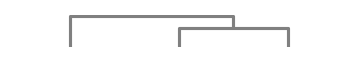

In [50]:
a,fig,gs = rz.startfig(6,1)
col_link = hierdict['col_link']
dendro = scipy.cluster.hierarchy.dendrogram(
                                 col_link, orientation='top', ax=a,
                                 above_threshold_color='0.5',
                                 color_threshold = 0,
                                    )

a.set_xticklabels(heat.columns,rotation=270,fontsize=5)
a.set_xticks([])
a.axis('off')
rz.showspines(a)

gs.tight_layout(fig)
fname = outdir+'/dendrogram_NOlabels_tumor_%s_%s.pdf'%(thelabel,rz.now())
print(fname)
plt.savefig(fname, transparent=True, dpi=300)

## Plot heatmap

In [37]:
heat2 = heat

In [38]:
import matplotlib as mpl
mpl.rc('font',family='Arial')

In [40]:

def yticks_fancy(a,totick,labels_all, color_dict,emptychar = '',fontsize=5):
    
    """
    utility function originally made for ticking only a subset of selected genes in a genes x observations heatmap.
    example of use: yticks_fancy(a,['Csf1r','Ccr2','','','Arg1','S100a9'],genes_by_cells.index)
    input:
        a - axis with heatmap
        totick - list of yticklabels to display. Use the string defined by
        emptychar to add spacing between groups of genes.
        labels_all - all yticklabels.
        emptychar - string that will be treated as white space
        
    returns: nothing
    
    """


    a.set_yticks([])
    leftshift = 0
    totick = np.array(totick)
    nr_slots = len(totick)
    tickmask = np.array([i!=emptychar for i in totick])
    totick = totick[tickmask]
    y_right = np.array([pd.Index(labels_all).get_loc(i) for i in totick])
    
    #if genes were not typed in in the correct order, account for that to avoid lines crossing
    tickorder = np.argsort(y_right)
    y_right = y_right[tickorder]
    totick = totick[tickorder]
    y_left = np.linspace(0,len(labels_all),nr_slots)[tickmask]
    for l,r,gene in zip(y_left,y_right,totick):
        a.plot((-0.8-leftshift,-0.5-leftshift),(r,r),lw=0.5,color='0.2')
        a.plot((-1.2-leftshift,-0.8-leftshift),(l,r),lw=0.5,color='0.2')
        a.plot((-1.5-leftshift,-1.2-leftshift),(l,l),lw=0.5,color='0.2')
        a.text(-1.6-(leftshift*1.6),l,gene,ha='right',va='center',fontsize=fontsize, color = color_dict[gene])

In [41]:
totick = heat.index

In [45]:
#variant 2 - percentage max expression

heat = centroids[genes].copy()
heat = heat.loc[:,heat.max() > 0]
heat = heat/heat.max()*100.
heat = heat.T

#choosing the colormap
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(
    name='cmap', 
    colors=['#D3D3D3', #grey
            #'#ff8080', 
            '#cc0000' #dark-red
           ])
#hierarchically cluster
import scipy.cluster
hierdict = rz.hier_cluster(heat, hier_clust_cols=True, method='ward',metric='sqrt_correlation')

print(hierdict.keys())

heat = hierdict['data']

dict_keys(['data', 'row_link', 'col_link'])


In [46]:
label = 'tumor_genes'

0.0 100.0
heatmap_pctmax995_tumor_tumor_genes_hq


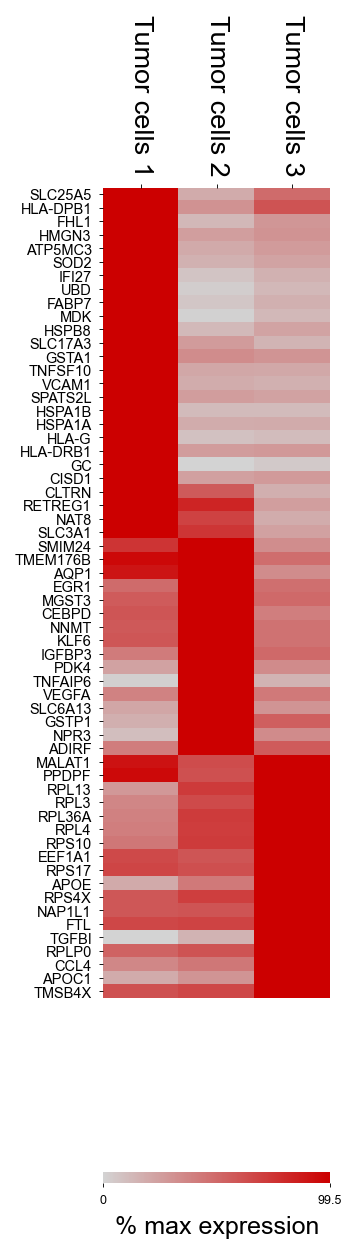

In [48]:

a,fig,gs = rz.startfig(6,23,frameon=False)

cmap = cmap
cbarlabel = '% max expression'

vmin=0
vmax=99.5

print(heat.min().min(),heat.max().max())

# heatmap
hmap = a.imshow(heat,aspect='auto',vmin=vmin,vmax=vmax,cmap=cmap)

# x ticks
a.set_xticks(np.arange(heat.shape[1]))
a.set_xticklabels(heat.columns,rotation=270, fontsize=13)
a.xaxis.tick_top()

# y ticks:
a.set_yticks(np.arange(heat.shape[0]))
a.set_yticklabels(heat.index, fontsize =7)


# colorbar
cbar = fig.colorbar(hmap,orientation='horizontal')
cbar.outline.set_visible(False)

c = [vmin,vmax]
cbar.set_ticks(c)
cbar.set_ticklabels(c)
cbar.set_label(cbarlabel, fontsize=12)


gs.tight_layout(fig)
fname = 'heatmap_pctmax995_tumor_%s_hq'%(label)
print(fname)

plt.savefig(outdir+'%s.png'%fname,dpi=600)
plt.savefig(outdir+'%s.pdf'%fname,dpi=600)